In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import plotnine as pn
import seaborn as sns
import gseapy
from statannotations.Annotator import Annotator

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150, dpi_save= 300, fontsize=10, frameon=True, figsize=(3, 3), transparent=True, format="pdf")


-----
anndata     0.7.5
scanpy      1.8.1
sinfo       0.3.1
-----
OpenSSL             20.0.1
PIL                 8.1.1
adjustText          NA
anndata             0.7.5
anyio               NA
appdirs             1.4.4
argon2              20.1.0
asciitree           NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bioservices         1.7.11
brotli              NA
bs4                 4.9.3
bson                NA
cairo               1.20.0
certifi             2021.10.08
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.3.0
colorama            0.4.4
colorlog            NA
cryptography        3.4.4
cycler              0.10.0
cython_runtime      NA
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
descartes           NA
docutils            0.16
easydev             0.11.0
fasteners           NA
future_fstrings     NA
google              NA
gridfs              NA
gseapy              0.10.4
h5py             

In [3]:
heart_infection_sc = sc.read_h5ad(filename="./../pyobjs_github/heart_infection_sc.h5ad")

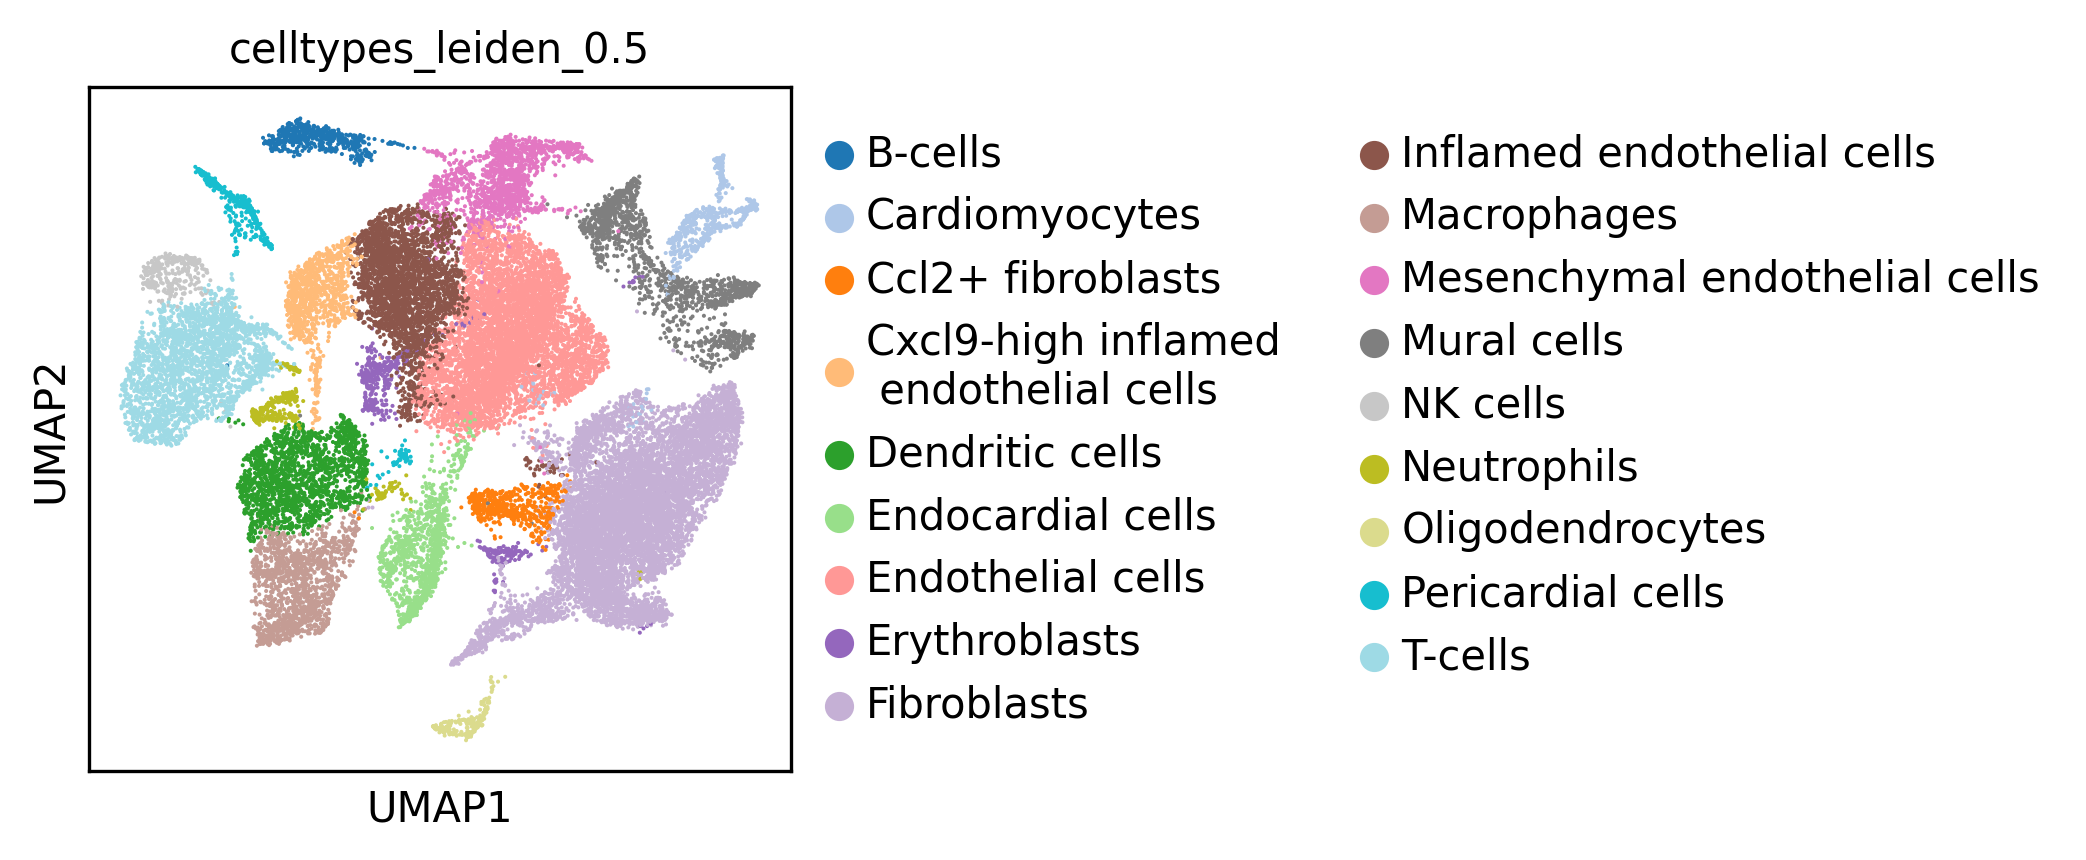

In [4]:
sc.pl.umap(heart_infection_sc, color = ['celltypes_leiden_0.5'], legend_fontsize=10)

In [5]:
heart_infection_sc.obs["condition"].cat.reorder_categories(new_categories=["Mock_D4PI", "T1L-WT_D4PI",  "Mock_D7PI",  "T1L-WT_D7PI",  "Mock_D10PI", "T1L-WT_D10PI"], inplace = True)

In [8]:
sc.tl.rank_genes_groups(heart_infection_sc, groupby = 'condition', groups= ["T1L-WT_D4PI"],
                        reference= 'Mock_D4PI', key_added='rank_genes_T1L-WT_vs_Mock_D4PI',
                        method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_T1L-WT_vs_Mock_D4PI']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:28)


In [9]:
day4_WT_infection_markers = sc.get.rank_genes_groups_df(heart_infection_sc, group="T1L-WT_D4PI", key="rank_genes_T1L-WT_vs_Mock_D4PI")

# Genes with > 10 log fold change are sex specific genes like Xist, Tsix. 
day4_WT_infection_markers = day4_WT_infection_markers[day4_WT_infection_markers["logfoldchanges"] < 10]
day4_WT_infection_markers = day4_WT_infection_markers.sort_values(by= "scores", ascending=False)
print(day4_WT_infection_markers)
# day4_WT_infection_markers.to_csv("./../csvs/heart_IFN_genelist_D4PI.csv")
day4_WT_infection_markers_significant = day4_WT_infection_markers[day4_WT_infection_markers["logfoldchanges"] > 1.0]
day4_WT_infection_markers_significant = day4_WT_infection_markers_significant[day4_WT_infection_markers_significant["pvals_adj"] < 0.01]

          names     scores  logfoldchanges          pvals      pvals_adj
0        Ifitm3  85.555222        3.635777   0.000000e+00   0.000000e+00
1          Bst2  84.066872        5.022720   0.000000e+00   0.000000e+00
3         Isg15  79.678001        6.908294   0.000000e+00   0.000000e+00
4           B2m  77.476456        3.591180   0.000000e+00   0.000000e+00
5      Ifi27l2a  60.614697        5.020513   0.000000e+00   0.000000e+00
...         ...        ...             ...            ...            ...
22752    Sptbn1 -17.735380       -0.533346   2.235772e-70   5.716794e-68
22753    mt-Nd4 -18.523550       -0.392755   1.333486e-76   3.570134e-74
22754     Ddx3y -23.827291      -28.863832  1.741682e-125  6.392816e-123
22755   mt-Cytb -24.240606       -0.434230  8.306780e-130  3.316446e-127
22756     Nedd4 -25.726536       -0.830774  5.902083e-146  2.487291e-143

[22387 rows x 5 columns]


In [10]:
# Prepaing gene list for GO term ernichment analysis
de_results = day4_WT_infection_markers_significant
de_results = de_results[(de_results["logfoldchanges"] > 1.0) & (de_results["pvals_adj"] < 0.01)]
glist = de_results['names'].squeeze().str.strip().tolist()
print(len(glist))

230


In [11]:
# GO_Biological_Process_2021, KEGG_2019_Mouse, WikiPathways_2019_Mouse
# Using GO_Biological_Process_2021 gene sets for enrichment analysis
enr_res = gseapy.enrichr(gene_list=glist, 
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway', 
                     cutoff = 0.01)

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:a3e462a8df95254cf26493189970a0ad
Done.



In [14]:
GO_results = enr_res.results
GO_results["-log p-value"] =  -1 * np.log10(GO_results["Adjusted P-value"]) 
GO_results["Term"] = [x.split(" (")[0] for x in GO_results["Term"]]
GO_results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,-log p-value
0,GO_Biological_Process_2021,cellular response to type I interferon,25/65,3.773950e-32,2.911602e-29,0,0,60.152439,4352.305711,IFITM3;SP100;ADAR;IFI35;IFIT1;SAMHD1;IFIT3;IFI...,28.535868
1,GO_Biological_Process_2021,type I interferon signaling pathway,25/65,3.773950e-32,2.911602e-29,0,0,60.152439,4352.305711,IFITM3;SP100;ADAR;IFI35;IFIT1;SAMHD1;IFIT3;IFI...,28.535868
2,GO_Biological_Process_2021,defense response to virus,28/133,1.475151e-27,7.587191e-25,0,0,25.960396,1603.860198,IFITM3;RTP4;NLRC5;IFIT1;SAMHD1;IFIT3;IFIT2;IFI...,24.119919
3,GO_Biological_Process_2021,defense response to symbiont,27/124,4.989139e-27,1.924560e-24,0,0,26.975319,1633.693657,IFITM3;RTP4;NLRC5;IFIT1;SAMHD1;IFIT3;IFIT2;IFI...,23.715668
4,GO_Biological_Process_2021,cytokine-mediated signaling pathway,44/621,1.777345e-22,5.484887e-20,0,0,7.868769,394.081720,IFITM3;SP100;CXCL9;SPI1;ADAR;IFI35;IFIT1;SAMHD...,19.260832
...,...,...,...,...,...,...,...,...,...,...,...
1538,GO_Biological_Process_2021,transcription by RNA polymerase II,1/320,9.760371e-01,9.785740e-01,0,0,0.266266,0.006458,IRF9,0.009406
1539,GO_Biological_Process_2021,"regulation of transcription, DNA-templated",17/2244,9.797090e-01,9.816176e-01,0,0,0.628714,0.012888,BATF2;CD74;SP100;DAXX;SPI1;DTX3L;SP110;PCGF5;S...,0.008058
1540,GO_Biological_Process_2021,gene expression,1/356,9.843108e-01,9.855883e-01,0,0,0.238822,0.003777,ADAR,0.006304
1541,GO_Biological_Process_2021,organelle organization,1/420,9.926244e-01,9.930474e-01,0,0,0.201676,0.001493,CCL2,0.003030


In [ ]:
# This is to select GO terms of interest from the significanlt enriched GO terms
# GO_results = GO_results.iloc[[1,2,3,4,5,7,12,13,14,15,18,21,23,24,27,29,30,33,34,35],]

<ipython-input-15-134b7e8a653c>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
<ipython-input-15-134b7e8a653c>:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


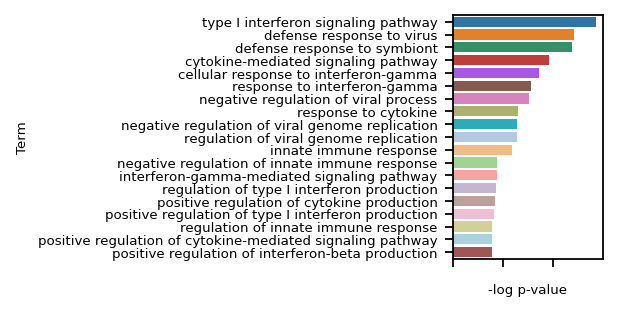

In [15]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, facecolor='white', frameon=True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize=(1.2,2.0))
plt.rc('font', size=6)
ax.set_axisbelow(True)
plt.grid(b=None)
g = sns.barplot(y = "Term", x = "-log p-value", data= GO_results[1:20], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.tight_layout()
plt.show()

In [16]:
gene_list = list(list(day4_WT_infection_markers_significant["names"][1:30]))
print(gene_list)

['Bst2', 'Isg15', 'B2m', 'Ifi27l2a', 'Iigp1', 'H2-K1', 'Irf7', 'H2-D1', 'Ly6e', 'Psmb8', 'Ifit3', 'Ifit1', 'Gbp7', 'Ly6a', 'Rtp4', 'Lgals3bp', 'H2-Q7', 'Xaf1', 'H2-T23', 'Oasl2', 'Rsad2', 'Rnf213', 'Gbp3', 'Psmb9', 'Psmb10', 'Lgals9', 'Ifi203', 'Irgm1', 'Ifit2']


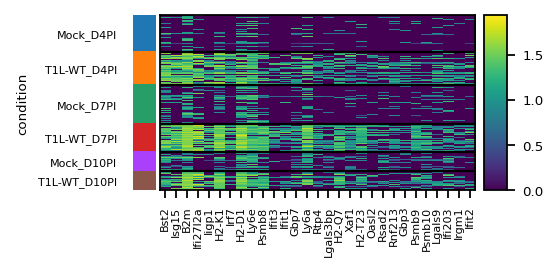

In [17]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, facecolor='white', frameon=True, vector_friendly = False, transparent=True, format="pdf")
sc.pl.heatmap(heart_infection_sc[heart_infection_sc.obs["condition"].isin(["Mock_D4PI", "Mock_D7PI", "Mock_D10PI", "T1L-WT_D4PI", "T1L-WT_D7PI", "T1L-WT_D10PI"]),:], var_names = gene_list, groupby="condition", log=True, show_gene_labels=True, figsize=(3,1.5))
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(2, 2))

In [18]:
sc.tl.score_genes(heart_infection_sc, gene_list, use_raw=True, score_name = 'Infection_response_score')

computing score 'Infection_response_score'
    finished: added
    'Infection_response_score', score of gene set (adata.obs).
    147 total control genes are used. (0:00:01)


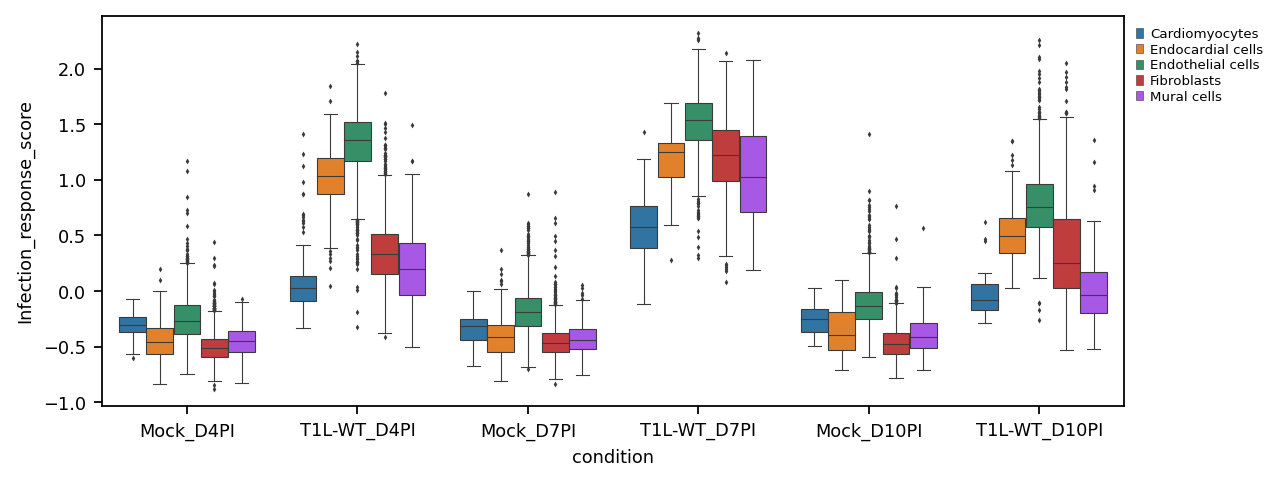

In [23]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=8, facecolor='white', frameon=True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize=(8, 3))
plt.rc('font', size=6)
ax.set_axisbelow(True)
plt.grid(False)
sns.boxplot(data = heart_infection_sc[heart_infection_sc.obs['celltype_groups'].isin(["Cardiomyocytes", "Fibroblasts", "Endothelial cells", "Mural cells", "Endocardial cells"]) & heart_infection_sc.obs['state'].isin(["Mock", "T1L-WT"])].obs, y= "Infection_response_score", x = "condition", linewidth = 0.5, fliersize = 0.5, hue = "celltype_groups", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='center')
plt.legend(ncol=1, prop={'size': 6}, handletextpad=0.5, markerscale = 0.6, frameon = False, labelspacing = 0.2, bbox_to_anchor = (1.0,1.0))
plt.tight_layout()
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mock_D7PI_Endocardial cells vs. Mock_D7PI_Endothelial cells: Mann-Whitney-Wilcoxon test two-sided, P_val:3.599e-74 U_stat=1.674e+05
T1L-WT_D4PI_Endothelial cells vs. T1L-WT_D4PI_Fibroblasts: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=4.852e+06
Mock_D4PI_Endothelial cells vs. Mock_D4PI_Fibroblasts: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=5.436e+06
Mock_D4PI_Endocardial cells vs. Mock_D4PI_Endothelial cells: Mann-Whitney-Wilcoxon test two-sided, P_val:7.071e-49 U_stat=1.215e+05
T1L-WT_D4PI_Endocardial cells vs. T1L-WT_D4PI_Endothelial cells: Mann-Whitney-Wilcoxon test two-sided, P_val:5.351e-49 U_stat=1.138e+05
Mock_D7PI_Endothelial cells vs. Mock_D7PI_Fibroblasts: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=6.321e+06
Mock_D10PI_Endothelial cells vs. Mock

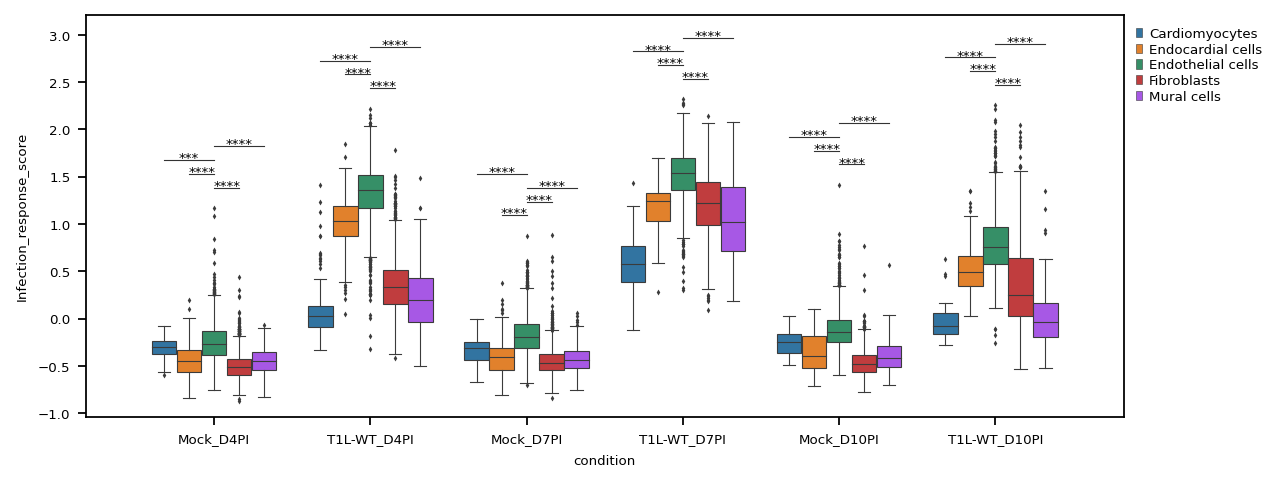

In [25]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, facecolor='white', frameon=True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize=(8, 3))
plt.rc('font', size=6)
ax.set_axisbelow(True)
plt.grid(False)
sns.boxplot(data = heart_infection_sc[heart_infection_sc.obs['celltype_groups'].isin(["Cardiomyocytes", "Fibroblasts", "Endothelial cells", "Mural cells", "Endocardial cells"]) & heart_infection_sc.obs['state'].isin(["Mock", "T1L-WT"])].obs, y= "Infection_response_score", x = "condition", linewidth = 0.5, fliersize = 0.5, hue = "celltype_groups", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='center')
plt.legend(ncol=1, prop={'size': 6}, handletextpad=0.5, markerscale = 0.6, frameon = False, labelspacing = 0.2, bbox_to_anchor = (1.0,1.0))
pairs=[(("Mock_D4PI", "Cardiomyocytes"), ("Mock_D4PI", "Endothelial cells")), 
       (("Mock_D4PI", "Fibroblasts"), ("Mock_D4PI", "Endothelial cells")),
       (("Mock_D4PI","Mural cells"), ("Mock_D4PI","Endothelial cells")),
       (("Mock_D4PI", "Endocardial cells"), ("Mock_D4PI", "Endothelial cells")),
      (("Mock_D7PI", "Cardiomyocytes"), ("Mock_D7PI", "Endothelial cells")), 
       (("Mock_D7PI", "Fibroblasts"), ("Mock_D7PI", "Endothelial cells")),
       (("Mock_D7PI","Mural cells"), ("Mock_D7PI","Endothelial cells")),
       (("Mock_D7PI", "Endocardial cells"), ("Mock_D7PI", "Endothelial cells")),
      (("Mock_D10PI", "Cardiomyocytes"), ("Mock_D10PI", "Endothelial cells")), 
       (("Mock_D10PI", "Fibroblasts"), ("Mock_D10PI", "Endothelial cells")),
       (("Mock_D10PI","Mural cells"), ("Mock_D10PI","Endothelial cells")),
       (("Mock_D10PI", "Endocardial cells"), ("Mock_D10PI", "Endothelial cells")),
      (("T1L-WT_D4PI", "Cardiomyocytes"), ("T1L-WT_D4PI", "Endothelial cells")), 
       (("T1L-WT_D4PI", "Fibroblasts"), ("T1L-WT_D4PI", "Endothelial cells")),
       (("T1L-WT_D4PI","Mural cells"), ("T1L-WT_D4PI","Endothelial cells")),
       (("T1L-WT_D4PI", "Endocardial cells"), ("T1L-WT_D4PI", "Endothelial cells")),
      (("T1L-WT_D7PI", "Cardiomyocytes"), ("T1L-WT_D7PI", "Endothelial cells")), 
       (("T1L-WT_D7PI", "Fibroblasts"), ("T1L-WT_D7PI", "Endothelial cells")),
       (("T1L-WT_D7PI","Mural cells"), ("T1L-WT_D7PI","Endothelial cells")),
       (("T1L-WT_D7PI", "Endocardial cells"), ("T1L-WT_D7PI", "Endothelial cells")),
      (("T1L-WT_D10PI", "Cardiomyocytes"), ("T1L-WT_D10PI", "Endothelial cells")), 
       (("T1L-WT_D10PI", "Fibroblasts"), ("T1L-WT_D10PI", "Endothelial cells")),
       (("T1L-WT_D10PI","Mural cells"), ("T1L-WT_D10PI","Endothelial cells")),
       (("T1L-WT_D10PI", "Endocardial cells"), ("T1L-WT_D10PI", "Endothelial cells"))]
annotator = Annotator(ax, pairs, data=heart_infection_sc[heart_infection_sc.obs['celltype_groups'].isin(["Cardiomyocytes", "Fibroblasts", "Endothelial cells", "Mural cells", "Endocardial cells"]) & heart_infection_sc.obs['state'].isin(["Mock", "T1L-WT"])].obs, x="condition", y="Infection_response_score", hue = "celltype_groups")
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', text_offset = -2, line_offset = -2, line_width = 0.5, line_height = 0, line_offset_to_group = 0)
annotator.apply_and_annotate()
plt.tight_layout()
plt.show()

In [26]:
# Counting cells acorss samples to compare cell type composition of sampels
counts = heart_infection_sc.obs.value_counts(subset=["state", "stage", "celltypes_leiden_0.5"]).unstack()
counts = counts.div(counts.sum(axis=1), axis=0)
counts = pd.DataFrame(counts.stack().astype("float"), columns=["Proportions"])
counts = counts.join(counts.index.to_frame())
counts.index = [i for i in range(counts.shape[0])]
# counts["celltype_groups"] = counts["celltypes_leiden_0.5"].astype("string")

In [28]:
counts["Condition"] = counts.apply(lambda x:'%s-%s' % (x['state'],x['stage']),axis=1)

In [29]:
print(counts)

     Proportions   state  stage celltypes_leiden_0.5     Condition
0       0.008945    Mock   D4PI              B-cells     Mock-D4PI
1       0.024560    Mock   D4PI       Cardiomyocytes     Mock-D4PI
2       0.006974    Mock   D4PI      Dendritic cells     Mock-D4PI
3       0.038811    Mock   D4PI    Endocardial cells     Mock-D4PI
4       0.288811    Mock   D4PI    Endothelial cells     Mock-D4PI
..           ...     ...    ...                  ...           ...
99      0.014191  T1L-WT  D10PI             NK cells  T1L-WT-D10PI
100     0.008978  T1L-WT  D10PI          Neutrophils  T1L-WT-D10PI
101     0.003765  T1L-WT  D10PI     Oligodendrocytes  T1L-WT-D10PI
102     0.027223  T1L-WT  D10PI    Pericardial cells  T1L-WT-D10PI
103     0.194324  T1L-WT  D10PI              T-cells  T1L-WT-D10PI

[104 rows x 5 columns]
